In [149]:
#importing all necessary libararies and packages for data pipeline and for model development, training, cross-validation 
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm_notebook, tnrange
from itertools import chain
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Flatten, Conv2D, Conv2DTranspose, MaxPooling2D, GlobalMaxPool2D, concatenate, add
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Lambda, RepeatVector, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
%matplotlib inline

In [133]:
# Setting some parameters for the grey scale vibration image data
im_width = 32
im_height = 32

In [135]:
#printing version of packages for future purpose in order to run it without any problem.
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.16.1
Numpy version:  1.26.4
Pandas version:  2.2.2
Scikit-learn version:  1.5.1


In [137]:
# loading data in npz which is numpy compressed data format which allows efficient data processsing
file = np.load('CWRU_48k_load_1_CNN_data.npz') # Give path to downloaded file in your system
#print subfiles available in the main file
print(file.files)

['data', 'labels']


In [139]:
#verifying size of inputs and output labels
data = file['data']
labels = file['labels']
print(data.shape, labels.shape)

(4600, 32, 32) (4600,)


In [141]:
#printing some data samples
print(data[0])
print(labels)

[[-0.041097  -0.046104  -0.028372  ... -0.042975  -0.11453   -0.17711  ]
 [-0.23052   -0.26348   -0.26077   ... -0.023782  -0.11787   -0.18775  ]
 [-0.20882   -0.19297   -0.15208   ... -0.017524  -0.063628  -0.11411  ]
 ...
 [ 0.02253   -0.049859  -0.11098   ... -0.036508  -0.03317   -0.02858  ]
 [-0.0031292  0.030249   0.063419  ... -0.035882  -0.010014   0.030875 ]
 [ 0.06029    0.072598   0.076145  ...  0.13602    0.10139    0.066548 ]]
['Ball_007' 'Ball_007' 'Ball_007' ... 'Normal' 'Normal' 'Normal']


In [143]:
#checking the number of unique lables in the dataset
category_labels = np.unique(labels)
print(category_labels)

['Ball_007' 'Ball_014' 'Ball_021' 'IR_007' 'IR_014' 'IR_021' 'Normal'
 'OR_007' 'OR_014' 'OR_021']


In [145]:
#Converting the labels into numbers so that the algorithm could be trained.
# there are 10 classes in the dataset and they have been assigned numbers from 0 to 10
labels = pd.Categorical(labels, categories = category_labels).codes
labels

array([0, 0, 0, ..., 6, 6, 6], dtype=int8)

In [79]:
#Splitting the data into training and cross-validation set
#Not validation is taken 20% from the training set during the training processs.
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 460, random_state = 42, 
                                                                    stratify = labels)

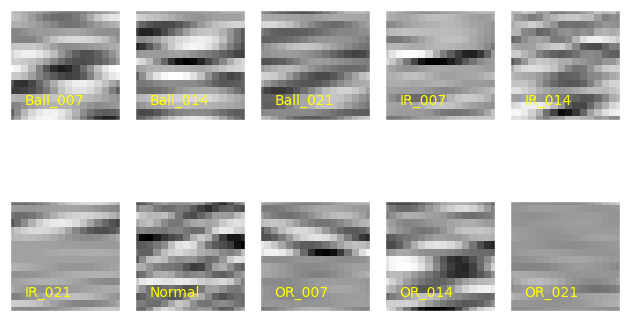

In [81]:
#printing the unique vibration image classes from the dataset with the assigned labels
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = train_data[train_labels == i][0].reshape(32, 32)
    ax[i].imshow(img, cmap='Greys')
    ax[i].text(2, 2, str(category_labels[i]), color='yellow')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.xlim(0, 15)
plt.ylim(0, 15)
plt.tight_layout()
plt.show()

In [83]:
# reshaping the data in order to feed to the model
train_data = train_data.reshape(4140,32,32,1)
test_data = test_data.reshape(460,32,32,1)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
#checking the final shape
print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape )

(4140, 32, 32, 1) (4140, 10) (460, 32, 32, 1) (460, 10)


In [85]:
# convoluation 2D block funciton that is used to develop UNET structure
def conv2d_block(input_tensor, n_filters, kernel_size = 2, batchnorm = True):
    
    """Function adds 2 convolutional layers with the parameters passed to it"""
    
    # 1st layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 2nd layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [99]:
#This function allows to define final UNET model using the previon convolutional functino and other layers.
def get_unet(input_img, n_filters = 4, dropout = 0.5, batchnorm = True):
    """Function uses the convolutional block from the aforementioned function"""
    
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 8, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 8, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 8, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 8, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    # Bridge
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 8, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 8, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 8, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 8, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 8, batchnorm = batchnorm)
    
    flat1 = Flatten()(c9)

    dense1 = Dense(10, activation='softmax')(flat1)

    model = Model(inputs = input_img, outputs = dense1, name = 'get_unet')
    return model

In [101]:
# Compling the final UNET structure
optimizer = Adam(learning_rate=1e-3)
input_img = Input((im_height, im_width, 1))
model = get_unet(input_img, n_filters=8, dropout=0.5, batchnorm=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=10)])

In [103]:
#summary of the final architecture including input and output shapes
model.summary()

Model: "get_unet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 32, 32, 8) │        520 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 8) │         32 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_55       │ (None, 32, 32, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 16, 8) │          0 │ activation_55[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 16, 16, 8) │          0 │ max_pooling2d_12… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 16, 16,    │      8,208 │ dropout_24[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │         64 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_57       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 8, 8, 16)  │          0 │ activation_57[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 8, 8, 16)  │          0 │ max_pooling2d_13… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 8, 8, 32)  │     32,800 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 32)  │        128 │ conv2d_59[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_59       │ (None, 8, 8, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 4, 4, 32)  │          0 │ activation_59[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 4, 4, 32)  │          0 │ max_pooling2d_14… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 4, 4, 64)  │    131,136 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 64)  │        256 │ conv2d_61[0][0] 

 Total params: 1,574,962 (6.01 MB)

 Trainable params: 1,574,226 (6.01 MB)

 Non-trainable params: 736 (2.88 KB)

In [105]:
#callbacks used to control learning rate and overfitting
callbacks = [
        EarlyStopping(patience=10, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000000001, verbose=1),
        #ModelCheckpoint('model-cwru.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [107]:
#Model training
res = np.empty(1)
res[:] = np.nan
for i in range(1):
    history = model.fit(train_data, train_labels, epochs=100, batch_size=64, callbacks=callbacks, validation_split=0.2)
    res[i] = model.evaluate(test_data, test_labels, batch_size=64)[1]           
    print('Loop iteration %d, Accuracy: %4.4f' % (i+1, res[i]))
    if res[i]>=np.max(res[:(i+1)]):
        best_model = model

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.3091 - loss: 1.9459 - mean_io_u_3: 0.4500 - val_accuracy: 0.3816 - val_loss: 1.8111 - val_mean_io_u_3: 0.4829 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.7372 - loss: 0.7130 - mean_io_u_3: 0.4505 - val_accuracy: 0.6473 - val_loss: 0.8331 - val_mean_io_u_3: 0.4698 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.8284 - loss: 0.4424 - mean_io_u_3: 0.4560 - val_accuracy: 0.8164 - val_loss: 0.4382 - val_mean_io_u_3: 0.4520 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.8580 - loss: 0.3740 - mean_io_u_3: 0.4567 - val_accuracy: 0.8756 - val_loss: 0.3259 - val_mean_io_u_3: 0.4599 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.8759 - loss: 0.3264 - mean_io_u_3: 0.4624 - val_accuracy: 0.8768 - val_loss: 0.2977 - val_mean_io_u_3: 0.4533 - learning_rate: 0.

In [147]:
#cheking the final accuracy 
print('Final accuracy:%4.4f'%(np.mean(res)))

Final accuracy:0.9826


In [111]:
# Fuction for plotting the learning curves
plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'navy', label='Training accuracy')
    plt.plot(x, val_acc, 'darkorange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'navy', label='Training loss')
    plt.plot(x, val_loss, 'darkorange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

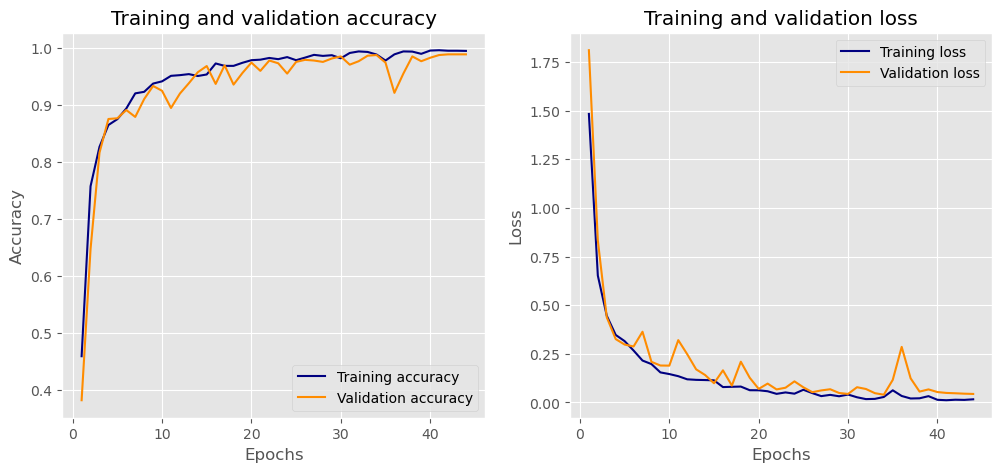

In [113]:
#plotting the learning curves
plot_history(history)

In [115]:
#cross-validating the final model
prediction = best_model.predict(test_data)
prediction_labels = list([])
for each_prediction in prediction:
    prediction_labels.append(list(each_prediction).index(max(each_prediction)))

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [117]:
#Getting the true labels for comparison 
from sklearn.metrics import confusion_matrix
true_labels = np.argmax(test_labels, axis = 1)

In [119]:
#computing the confusion matrix
cm = confusion_matrix(true_labels, prediction_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

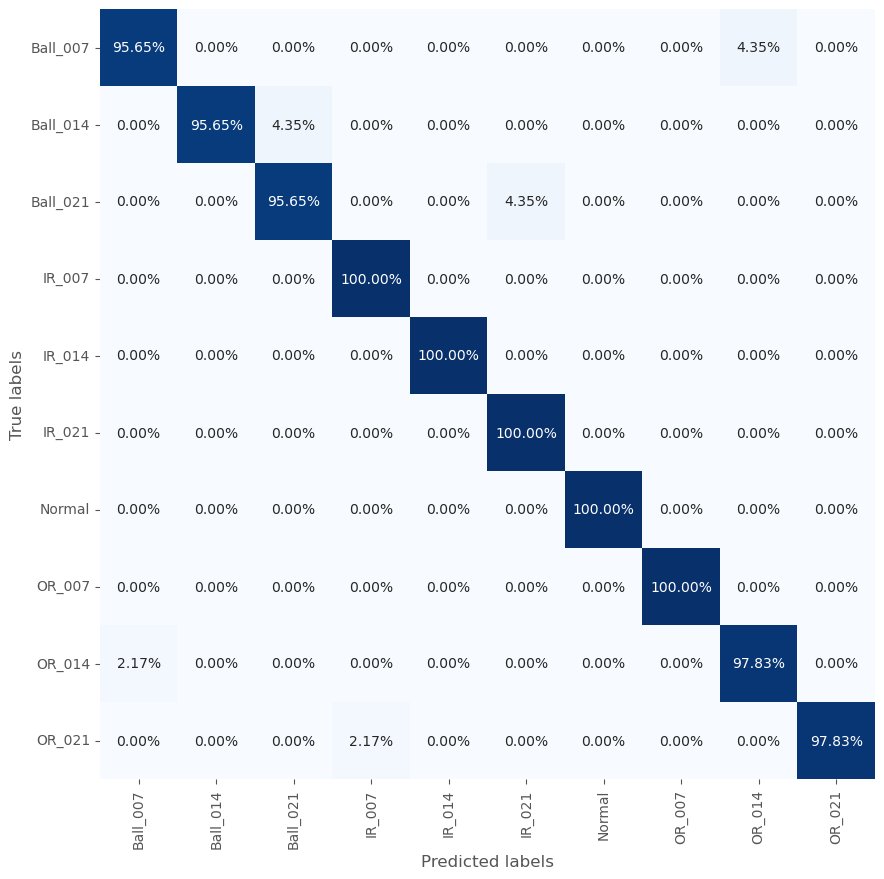

In [123]:
#Plotting the confusion matrix
matrix = pd.DataFrame(cm)
plt.figure(figsize = (10,10))
sns.heatmap(matrix, annot= True, fmt='.2%', 
           xticklabels = category_labels,
           yticklabels = category_labels, cmap = "Blues", cbar = False)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

In [125]:
#Overall classification report for individual class
print(classification_report(true_labels, prediction_labels, target_names=category_labels))

              precision    recall  f1-score   support

    Ball_007       0.98      0.96      0.97        46
    Ball_014       1.00      0.96      0.98        46
    Ball_021       0.96      0.96      0.96        46
      IR_007       0.98      1.00      0.99        46
      IR_014       1.00      1.00      1.00        46
      IR_021       0.96      1.00      0.98        46
      Normal       1.00      1.00      1.00        46
      OR_007       1.00      1.00      1.00        46
      OR_014       0.96      0.98      0.97        46
      OR_021       1.00      0.98      0.99        46

    accuracy                           0.98       460
   macro avg       0.98      0.98      0.98       460
weighted avg       0.98      0.98      0.98       460

